#  Brain-body-behavior descriptors ME

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
from qdax.utils.plotting import plot_2d_map_elites_repertoire

/home/giorgianadizar/miniconda3/envs/qdaxpy38/lib/python3.8/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/home/giorgianadizar/miniconda3/envs/qdaxpy38/lib/python3.8/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/giorgianadizar/miniconda3/envs/qdaxpy38/lib/python3.8/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.decl

In [2]:
%matplotlib inline

In [3]:
dfs = []
for sampler in ["all", "s1", "s2", "s3"]:
    for seed in range(10):
        tmp_df = pd.read_csv(f"../results/evo-body-5x5-me-{sampler}_{seed}.csv")
        tmp_df["sampler"] = sampler
        tmp_df["seed"] = seed
        dfs.append(tmp_df)
df = pd.concat(dfs)
df.head()

,iteration,max_fitness,qd_score1,qd_score2,qd_score3,coverage1,coverage2,coverage3,time,current_time,sampler,seed
0,1,0.498079,-4.571014,-3.111709,-0.778685,6.054688,3.515625,4.199219,10.259820,2024-04-04 13:17:12.380361,all,0
1,2,0.498079,-3.563980,-0.986565,2.178715,8.300781,3.613281,5.273438,6.047399,2024-04-04 13:17:18.428084,all,0
2,3,0.567185,-0.024876,2.097297,4.358453,9.667969,4.003906,6.835938,5.925249,2024-04-04 13:17:24.353723,all,0
3,4,0.567185,5.165858,2.803247,6.230591,10.839844,4.199219,8.398438,6.185898,2024-04-04 13:17:30.540099,all,0
4,5,0.567185,8.109872,3.158883,6.720121,12.011719,4.589844,9.960938,6.159141,2024-04-04 13:17:36.699699,all,0


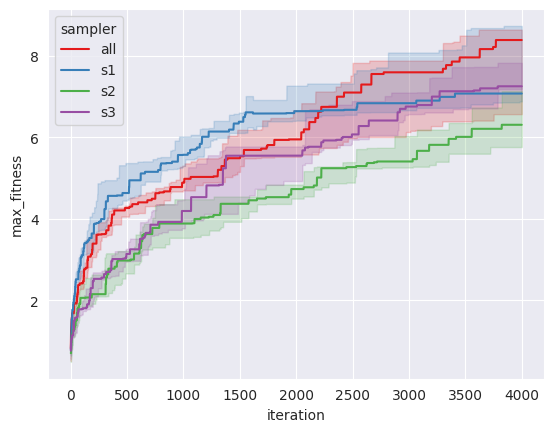

In [4]:
sns.lineplot(df,
             x="iteration",
             y="max_fitness",
             estimator="median",
             errorbar=("pi", 50),
             hue="sampler",
             palette="Set1",
             )
plt.show()

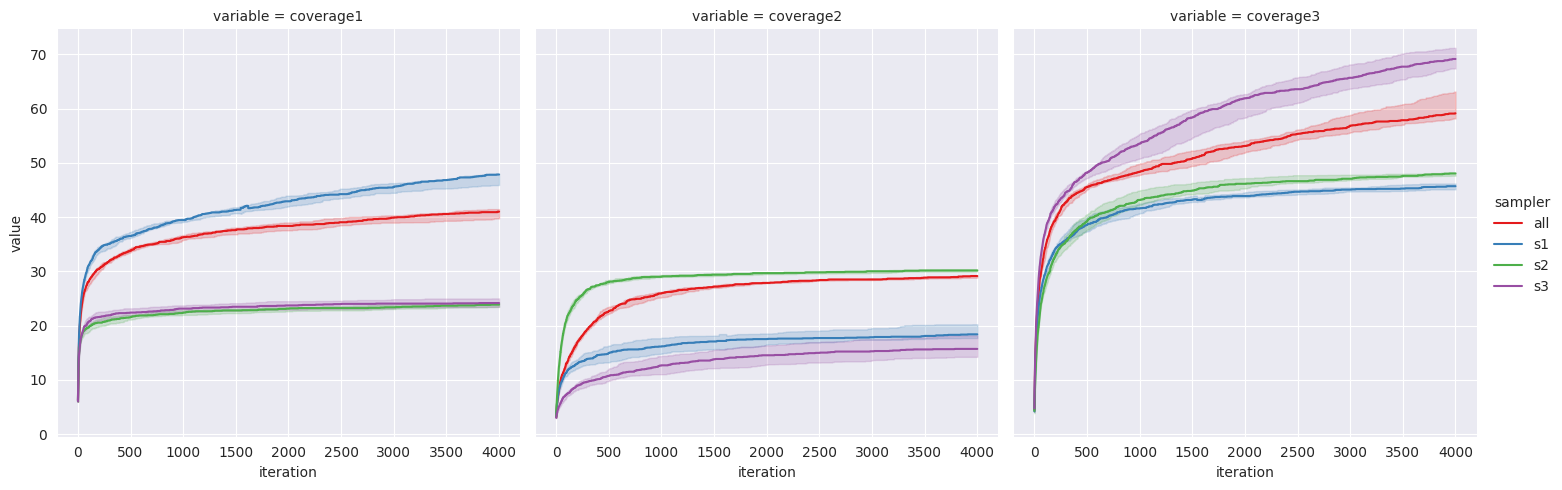

In [6]:
df_wide = pd.melt(df, id_vars=["iteration", "max_fitness", "time", "current_time", "sampler", "seed"],
                  value_vars=["coverage1", "coverage2", "coverage3"])
sns.relplot(df_wide,
            x="iteration",
            y="value",
            col="variable",
            hue="sampler",
            palette="Set1",
            kind="line",
            estimator="median",
            errorbar=("pi", 50),
            )
plt.show()

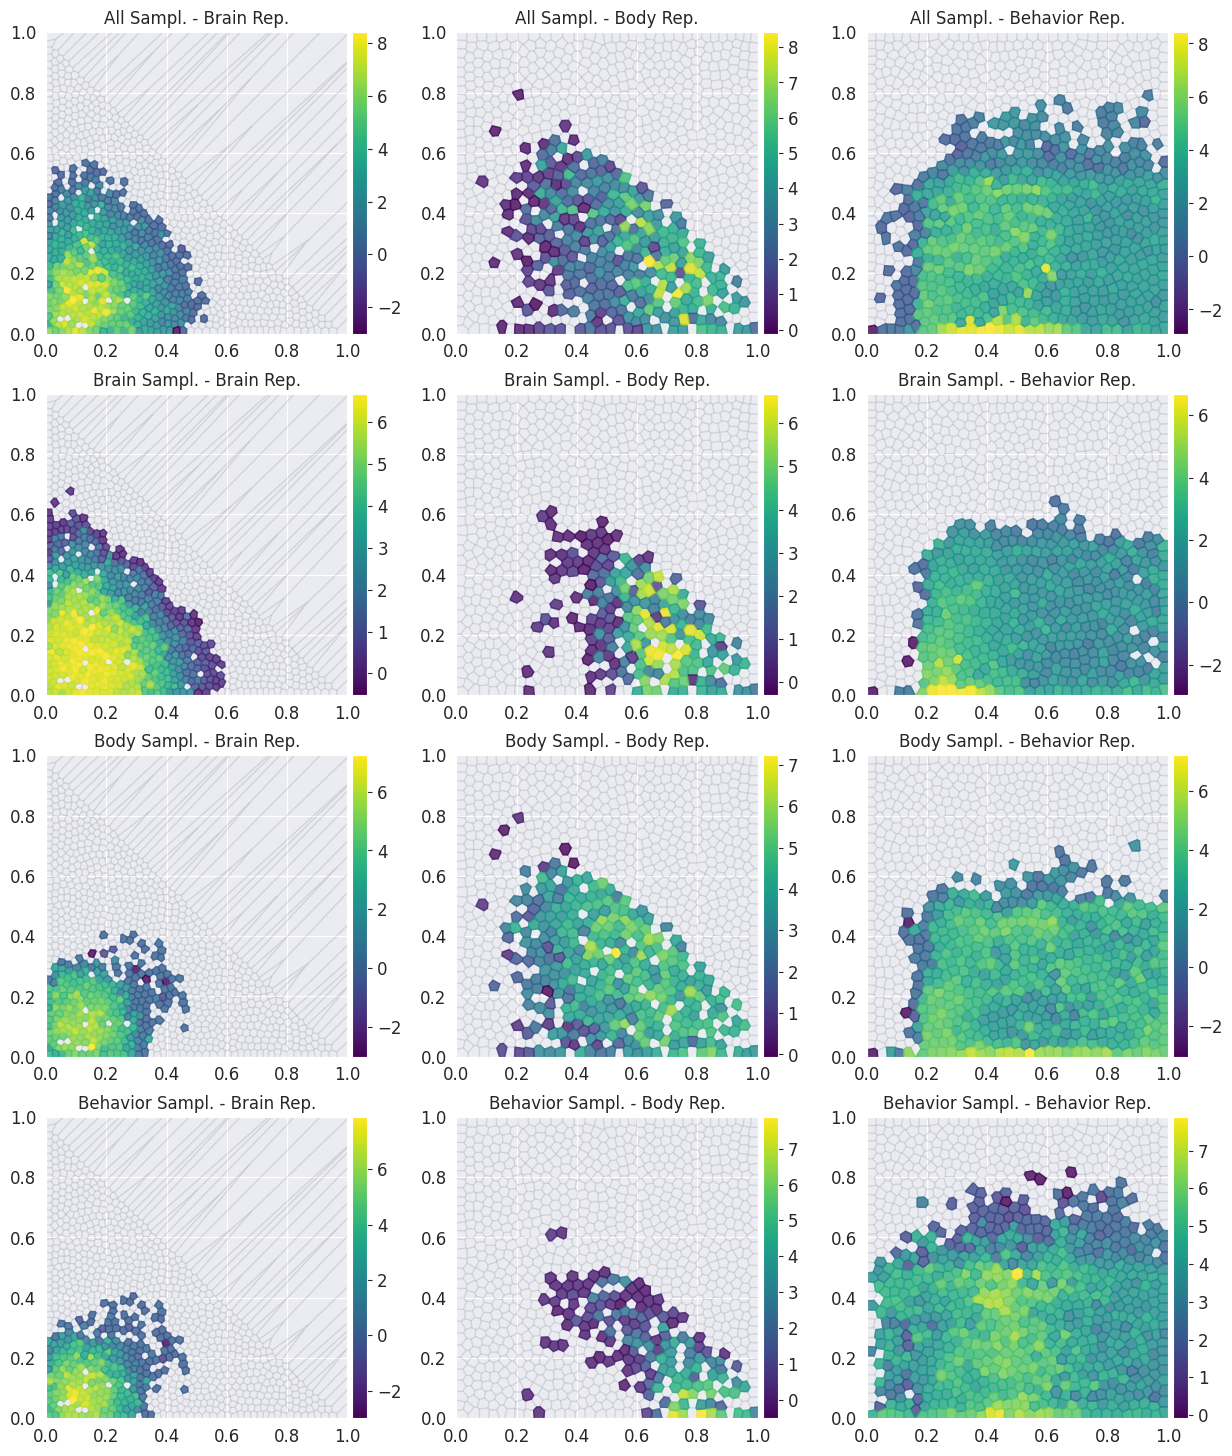

In [11]:
samplers = ["all", "s1", "s2", "s3"]
fig, axs = plt.subplots(4, 3, figsize=(15, 18))
reps = {
    0: "Brain",
    1: "Body",
    2: "Behavior"
}
sams = {
    "all": "All",
    "s1": "Brain",
    "s2": "Body",
    "s3": "Behavior"
}
for i, sampler in enumerate(samplers):
    base_path = f"../results/evo-body-5x5-me-{sampler}_0"
    for r, ax in enumerate(axs[i]):
        centroids = jnp.load(f"{base_path}/r{r + 1}_centroids.npy")
        fitnesses = jnp.load(f"{base_path}/r{r + 1}_fitnesses.npy")
        plot_2d_map_elites_repertoire(centroids, fitnesses, 0, 1, ax=ax)
        ax.set_title(f"{sams[sampler]} Sampl. - {reps[r]} Rep.")
        ax.set_xlabel("")
        ax.set_ylabel("")
plt.show()